# Cardio Catch Disease Project

## Descrição do Problema

**A Empresa (ficticia)**
- A cardio Catch Disease é uma empresa especializada em detecção de doenças cardíacas em estágios iniciais. O modelo de negócio é do tipo Serviço, ou seja, a empresa oferece o diagnostico precoce de uma doença cardiovascular por um certo preço.


**Problema de Negócio**
- Atualmente o diagnostico é feito manualmente por uma equipe de especialistas. A precisão atual varia entre 55% a 65%, devido a complexidade do diagnostico e também da fadiga da equipe que se reveza em turnos para minimizar os riscos. O custo de cada diagnostico, incluindo os aparelhos e a folha de pagamento dos analistas gira em torno de R$1.000,00.

- O preço do diagnostico pago pelo cliente varia de acordo com a precisão conseguida pelo time de especialistas, o cliente paga R$500,00 a cada 5% de acurácia acima de 50%.


**Objetivo**
- Criar uma ferramenta que aumente a precisão do diagnóstico e que essa precisão seja estável para todos os diagnosticos.

**Perguntas para responder**
- Qual acurácia e precisão da ferramenta
- Quanto lucro a empresa passará a ter com a nova ferramenta
- Qual a confiabilidade do resultado dos dados pela nova ferramenta?

# 0.0. Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb

from IPython.display         import Image
from IPython.core.display    import HTML
from matplotlib              import pyplot        as plt
from sklearn.model_selection import train_test_split
from sklearn                 import neighbors     as nh
from sklearn.metrics         import accuracy_score, f1_score, recall_score
from sklearn                 import linear_model  as lm
from sklearn                 import ensemble      as en
from lightgbm                import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn                 import preprocessing as pp
from sklearn.ensemble        import RandomForestRegressor

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
   

    display( HTML( '') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    
    
def cross_validation( model_name, model, X, y ):
    
    cv_score = cross_val_score( model, X, y, cv=5, scoring='accuracy')
    cv_f1score = cross_val_score( model, X, y, cv=5, scoring='f1')
    cv_recall = cross_val_score( model, X, y, cv=5, scoring='recall')

    score_mean = round( np.mean( cv_score ), 3 )
    score_std = round( np.std( cv_score ), 3 )
    
    f1_mean = round( np.mean( cv_f1score ), 3 )
    f1_std = round( np.std( cv_f1score ), 3 )
    
    recall_mean = round( np.mean( cv_recall ), 3 )
    recall_std = round( np.std( cv_recall ), 3 )
    
    return pd.DataFrame( { 'Accuracy Score': ' {} +/- {} '.format( score_mean, score_std ),
                          'F1 Score': '{} +/- {}'.format( f1_mean, f1_std ),
                         'Recall Score': '{} +/- {}'.format( recall_mean, recall_std ) }, index=[model_name] )

In [3]:
jupyter_settings()

## Loading Dataset

In [4]:
df_raw = pd.read_csv( '../data/raw/cardio_train.csv', sep=';')

# 1.0 Data Description

In [6]:
df1 = df_raw.copy()

## Spliting to take a test dataset

In [7]:
df1['cardio'].value_counts(normalize=True)

0    0.5003
1    0.4997
Name: cardio, dtype: float64

In [8]:
X = df1.drop( 'cardio', axis=1 )
y = df1['cardio'].copy()

x_training, x_test, y_training, y_test = train_test_split( X, y, test_size=0.1, random_state=28 )

df1 = pd.concat( [x_training, y_training], axis=1 )
df_test = pd.concat( [x_test, y_test ], axis=1 )

In [9]:
df_test['cardio'].value_counts(normalize=True)

0    0.501143
1    0.498857
Name: cardio, dtype: float64

In [10]:
df1['cardio'].value_counts(normalize=True)

0    0.500206
1    0.499794
Name: cardio, dtype: float64

## 1.1.Column Names 

In [11]:
df1.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

## 1.2. Data Dimensions

In [13]:
print('Number of Rows: {}'.format( df1.shape[0] ))
print('Number of Columns: {}'.format( df1.shape[1] ))

Number of Rows: 63000
Number of Columns: 13


## 1.3. Data Types

In [14]:
df1.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

## 1.4. Check NA

In [15]:
df1.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

## 1.5. Descriptive Statistics

In [16]:
# Estatistica Descritiva
# Central Tendency - mean, median
ct1 = pd.DataFrame( df1.apply( np.mean ) ).T
ct2 = pd.DataFrame( df1.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( df1.apply( np.std ) ).T
d2 = pd.DataFrame( df1.apply( min ) ).T
d3 = pd.DataFrame( df1.apply( max ) ).T
d4 = pd.DataFrame( df1.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( df1.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( df1.apply( lambda x: x.kurtosis() ) ).T

# Concat
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,0.0,99999.0,99999.0,49962.531063,49938.5,28856.826649,0.000493,-1.199129
1,age,10798.0,23713.0,12915.0,19469.352032,19703.0,2468.012245,-0.307221,-0.823181
2,gender,1.0,2.0,1.0,1.350222,1.0,0.477039,0.627962,-1.605715
3,height,55.0,250.0,195.0,164.372841,165.0,8.219944,-0.697752,8.629868
4,weight,10.0,200.0,190.0,74.187552,72.0,14.384827,1.017653,2.639800
5,ap_hi,-140.0,16020.0,16160.0,128.778683,120.0,152.352806,85.856894,7698.285470
6,ap_lo,-70.0,11000.0,11070.0,96.719048,80.0,188.535871,31.770352,1398.122439
7,cholesterol,1.0,3.0,2.0,1.367857,1.0,0.680265,1.582175,0.981197
8,gluc,1.0,3.0,2.0,1.225952,1.0,0.571583,2.401165,4.314433
9,smoke,0.0,1.0,1.0,0.087762,0.0,0.282948,2.913945,6.491281


# 2.0. Feature Engineering

In [17]:
df2 = df1.copy()

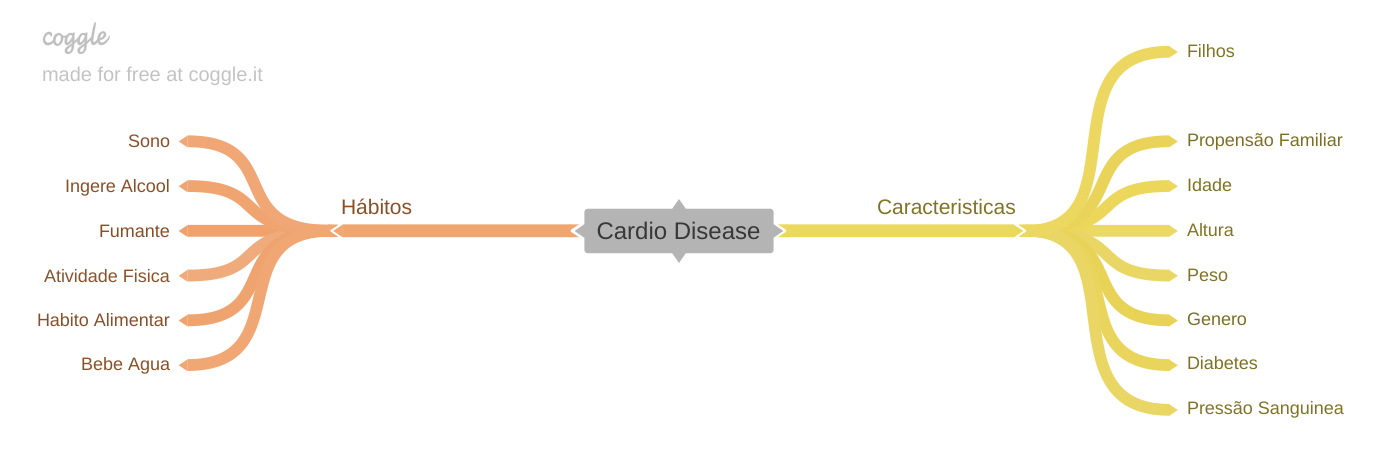

In [18]:
Image( 'C:/Users/Pedro/repos/cardio_diseases/cardio_catch_disease/img/cardio_disease.png' )

## Criação das Hipóteses

1. 50% das pessoas que fumam possuem doença cardiaca.
2. 80% das pessoas que praticam atividade fisica não possuem problemas cardiacos
3. Pessoas com imc elevado tendem a ter problemas cardiacos
4. Pessoas mais velhas tendem a ter problemas cardiacos.
5. Pessoas mais baixas tendem a ter problemas cardiacos.
6. Pessoas com habito alimentar ruim tendem a ter mais problemas cardiacos.
7. Pessoas com indice de colesterol mais altos tendem a ter problemas cardiacos.

## Feature Engineering

In [19]:
# Convertendo a coluna Age de dias para anos
df2['age'] = round(df2['age'] / 365)
df2['age'] = df2['age'].astype(np.int64)

In [20]:
# IMC
df2['imc'] = round( df2['weight'] / ( df2['height'] ** 2 ) * 10000, 2 )

In [21]:
# Sobrepeso
df2['sobrepeso'] = df2['imc'].apply( lambda x: 0 if x < 18.5 else 
                                   1 if ( 18.5 <= x < 24.9 ) else
                                   2 if ( 18.5 <= x < 24.9 ) else
                                   3 if ( 24.9 <= x < 29.9 ) else
                                   4 if ( 29.9 <= x < 39.9 ) else 5)

In [84]:
# Join the blood pressures
# df2['pressao'] = df2[['ap_hi', 'ap_lo']].astype(str).agg('/'.join, axis=1)

# 3.0. Filtragem de linhas e colunas

In [ ]:
# Remover Outliers: Pressão Sanguinea, Pesos, Alturas

In [22]:
df3 = df2.copy()

## Filtragem de linhas

In [23]:
# Removendo outliers da pressão sanguinea
df3 = df3.loc[ (df1['ap_hi'] < 190 ) & ( df1['ap_hi'] > 90 ), :]
df3 = df3.loc[ (df1['ap_lo'] < 110 ) & ( df1['ap_lo'] > 55 ), :]

In [24]:
# Removendo outliers da coluna Peso
df3 = df3.loc[ df3['weight'] > 40, : ]

In [25]:
# Removendo outliers da coluna altura
df3 = df3.loc[ df3['height'] > 110, : ]

## Filtragem das colunas

# 4.0. Exploratory Data Analysis

In [26]:
df4 = df3.copy()

## 4.1. Univariate Analysis

In [27]:
plt.style.use( 'bmh' )
plt.rcParams['figure.figsize'] = [25, 12]
plt.rcParams['font.size'] = 10
sns.set_theme(style="darkgrid")

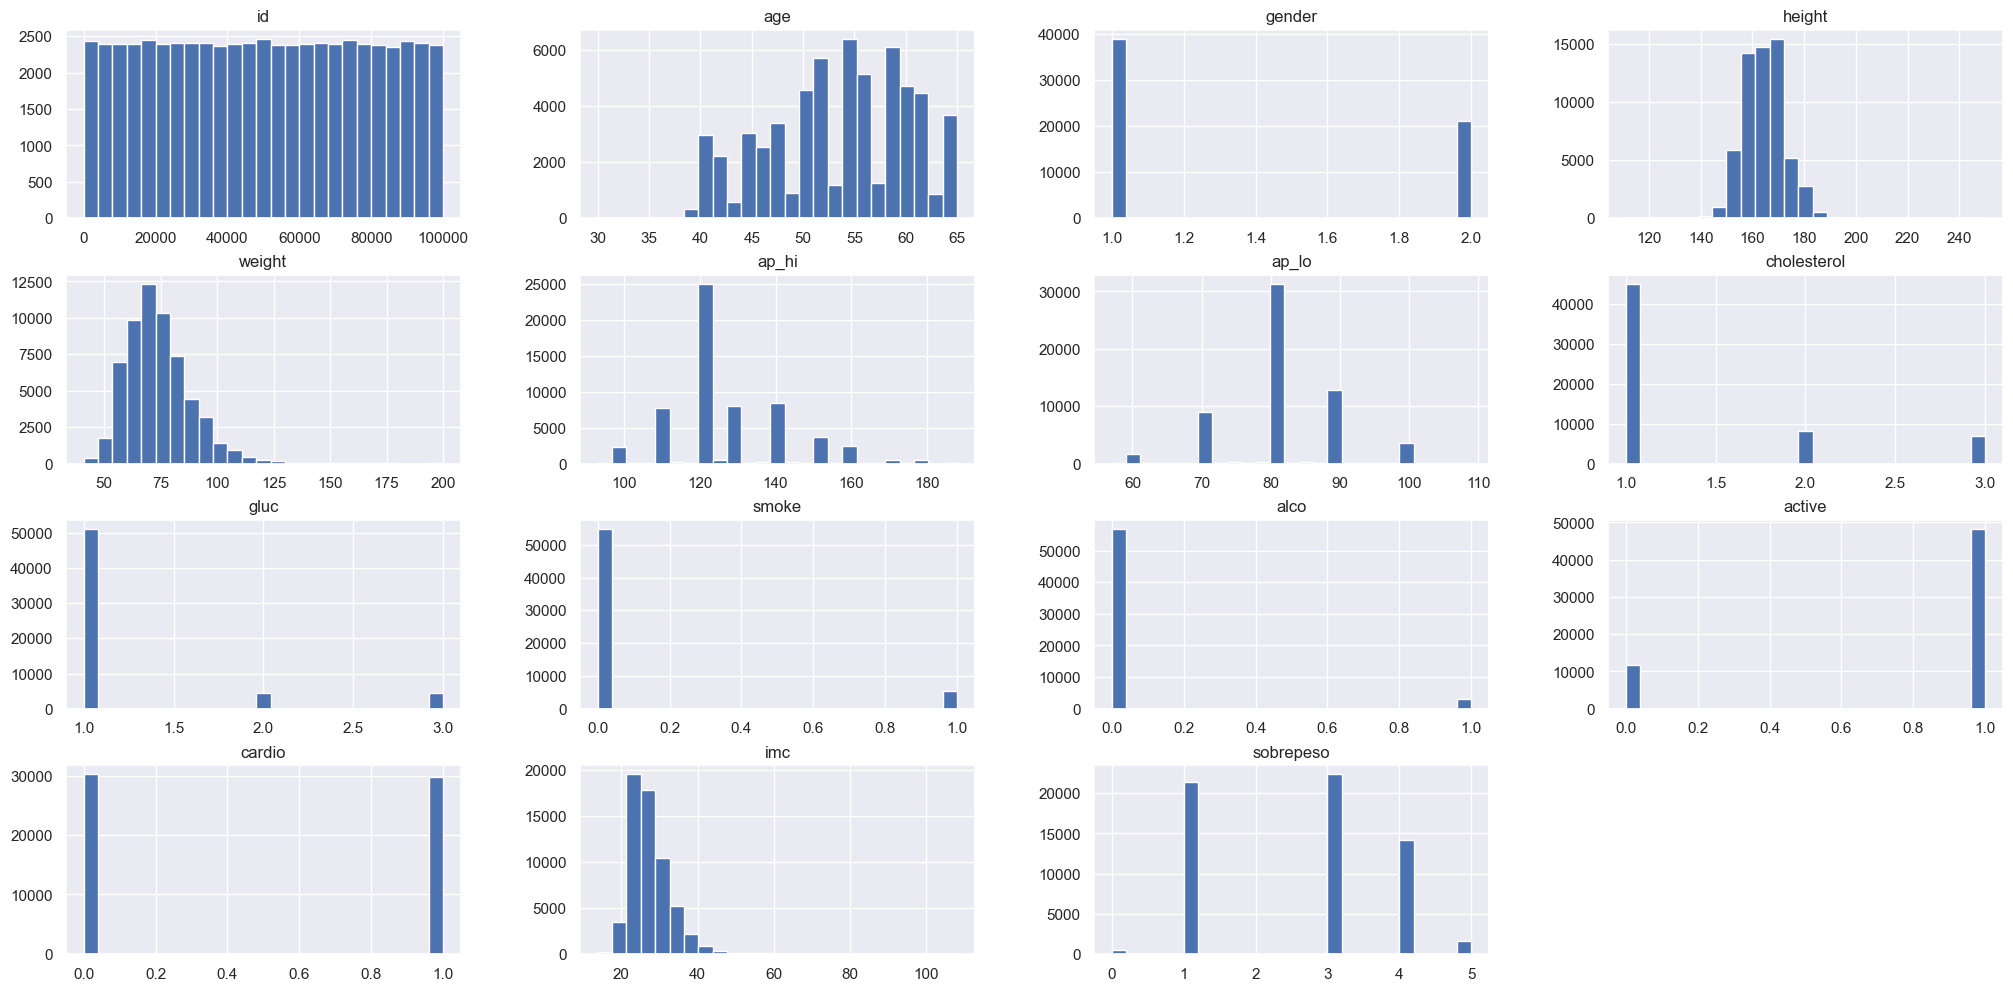

In [154]:
df4.hist(bins=25);

## 4.2. Bivariate Analysis

### 1. 50% das pessoas que fumam possuem doença cardiaca.
**Falso** - 46,78% das pessoas que fumam possuem doença cardiaca

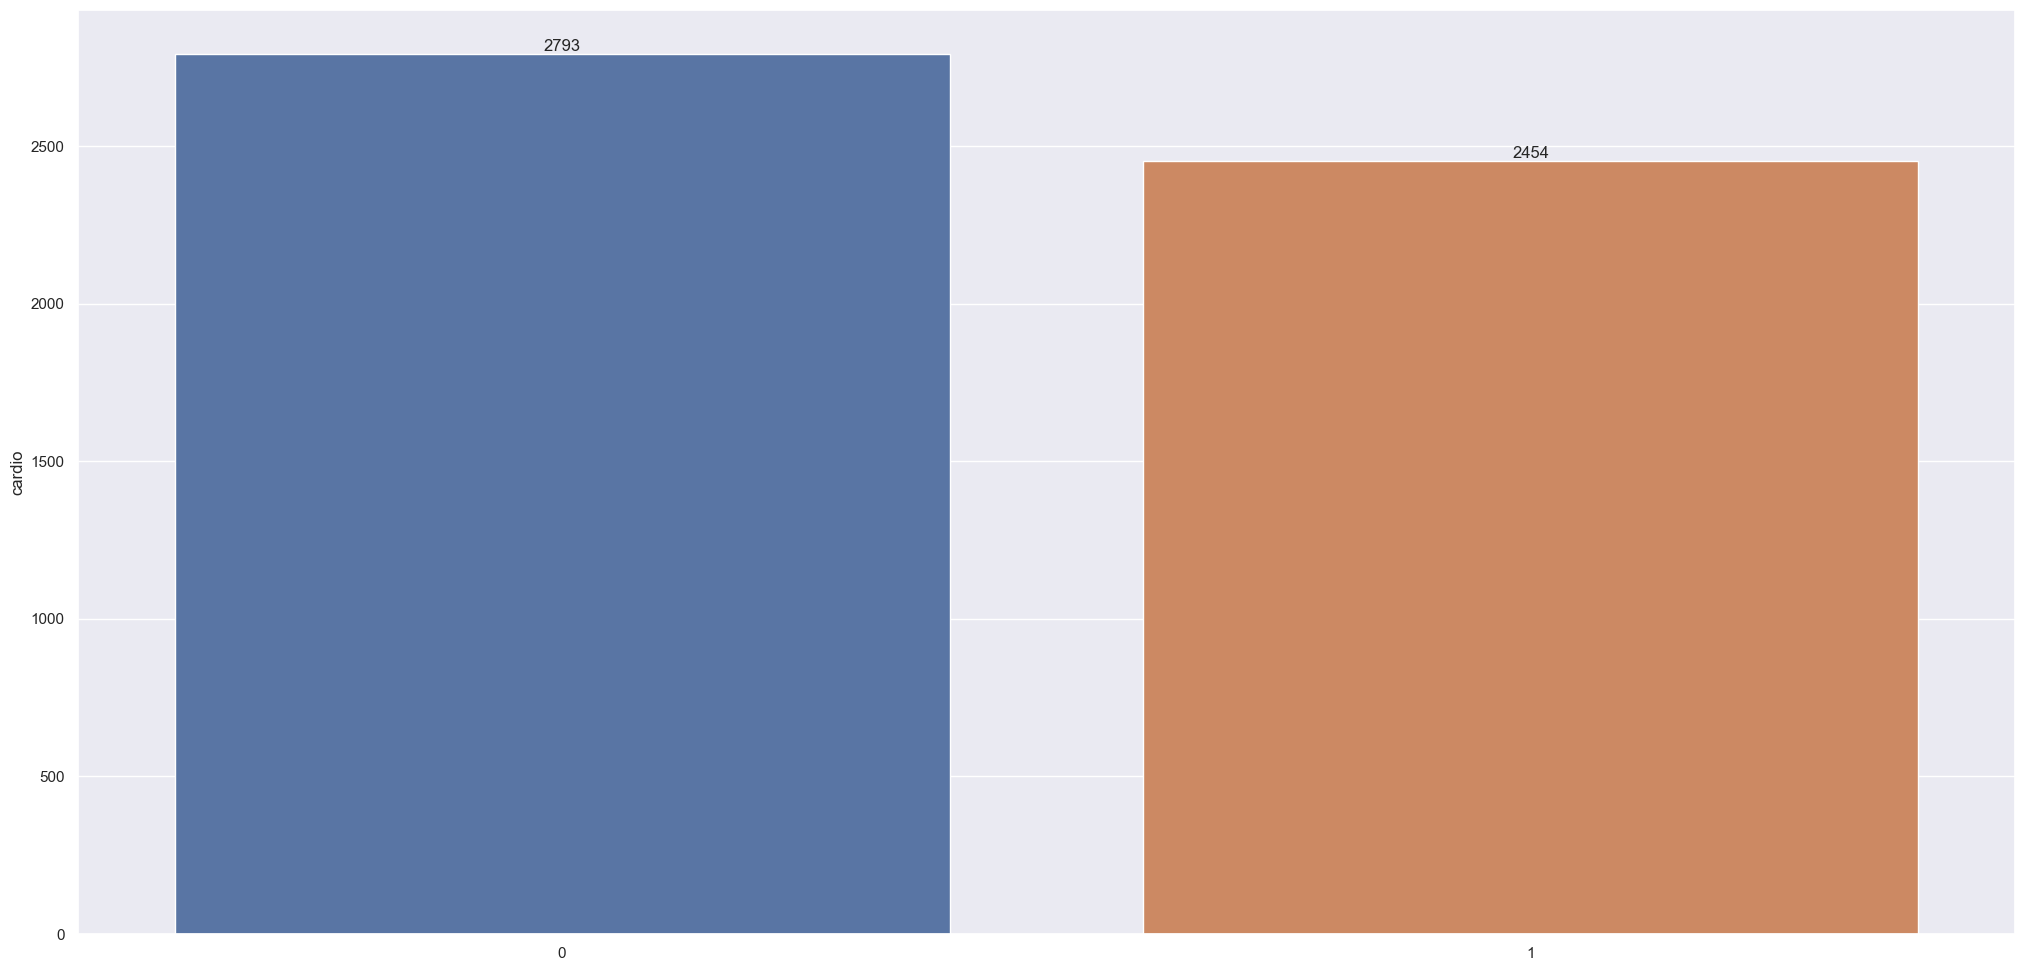

In [157]:
aux = df4.loc[df2['smoke']==1, :]

ax = sns.barplot( data=aux, x=aux['cardio'].unique(), y=aux['cardio'].value_counts() )

for i in ax.containers:
    ax.bar_label( i, )

### 2. 80% das pessoas que praticam atividade fisica não possuem problemas cardiacos
**Falso**: Apenas 51,36% das pessoas que praticam exercicio não possuem problemas cardiacos

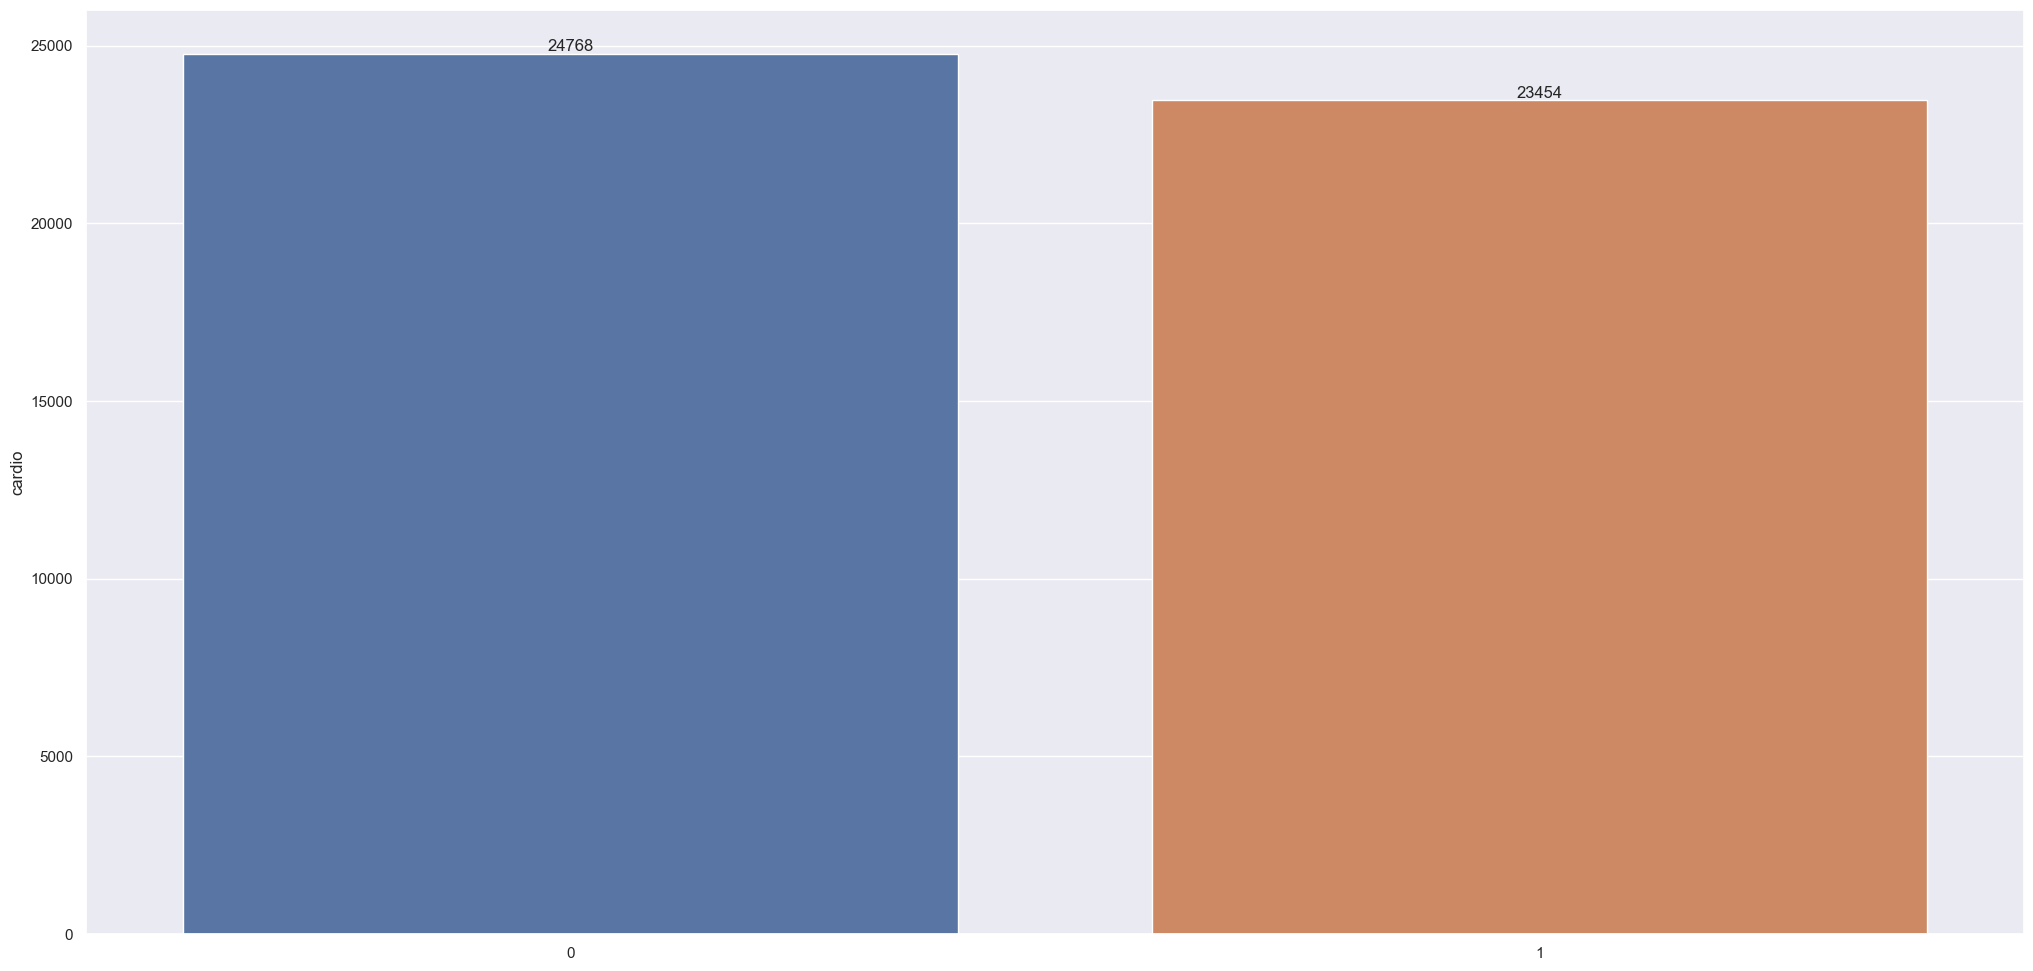

In [158]:
aux = df4.loc[df2['active']==1, :]

ax = sns.barplot( data=aux, x=aux['cardio'].unique(), y=aux['cardio'].value_counts() )

for i in ax.containers:
    ax.bar_label( i, )

### 3. Pessoas com imc elevado tendem a ter problemas cardiacos
**Verdadeiro**: Quanto maior o grau de sobrepeso, maior o numero de pessoas com problemas cardiacos

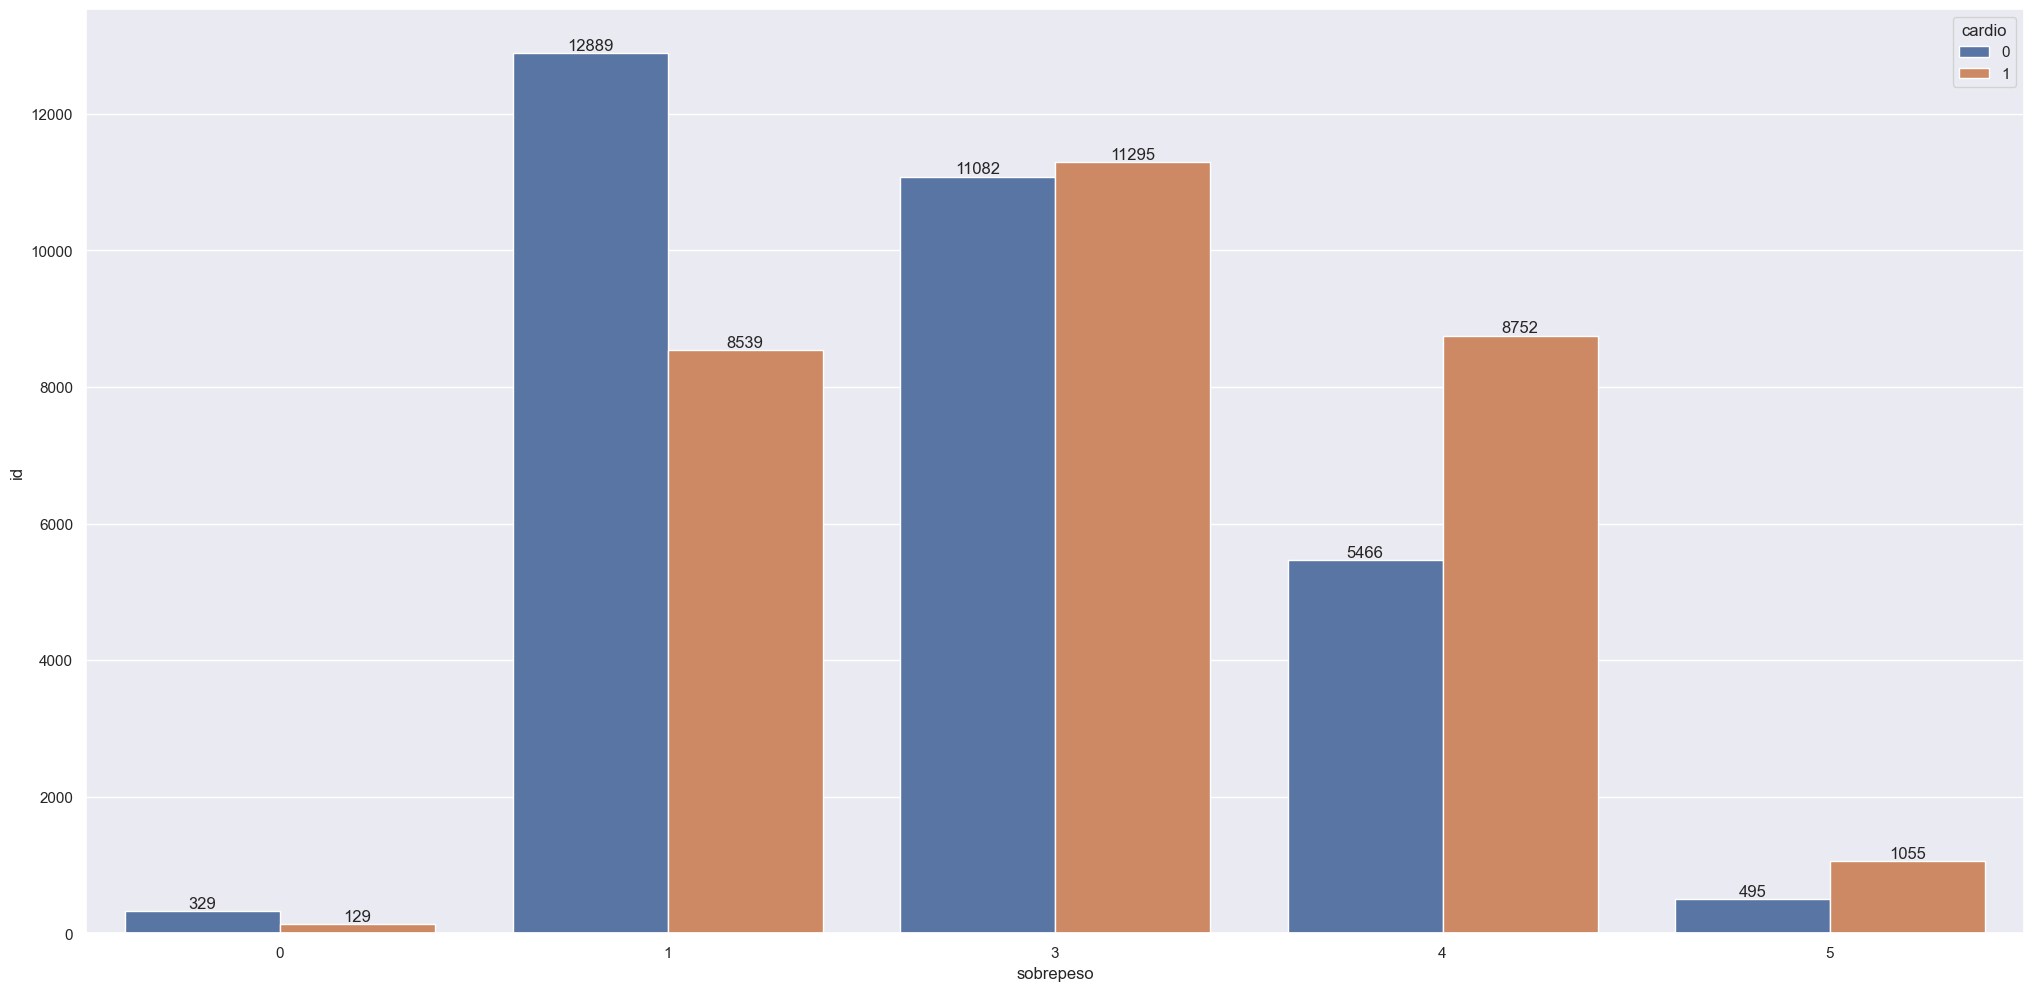

In [159]:
aux = df4[['sobrepeso', 'cardio', 'id' ]].groupby( ['sobrepeso', 'cardio'] ).count().reset_index()

ax = sns.barplot( data=aux, x='sobrepeso', y='id', hue='cardio' )
for i in ax.containers:
    ax.bar_label(i,)

### 4. Pessoas mais velhas tendem a ter problemas cardiacos.
**Verdadeiro**: Pessoas mais velhas tendem a ter problemas cardiacos

<AxesSubplot: xlabel='age', ylabel='id'>

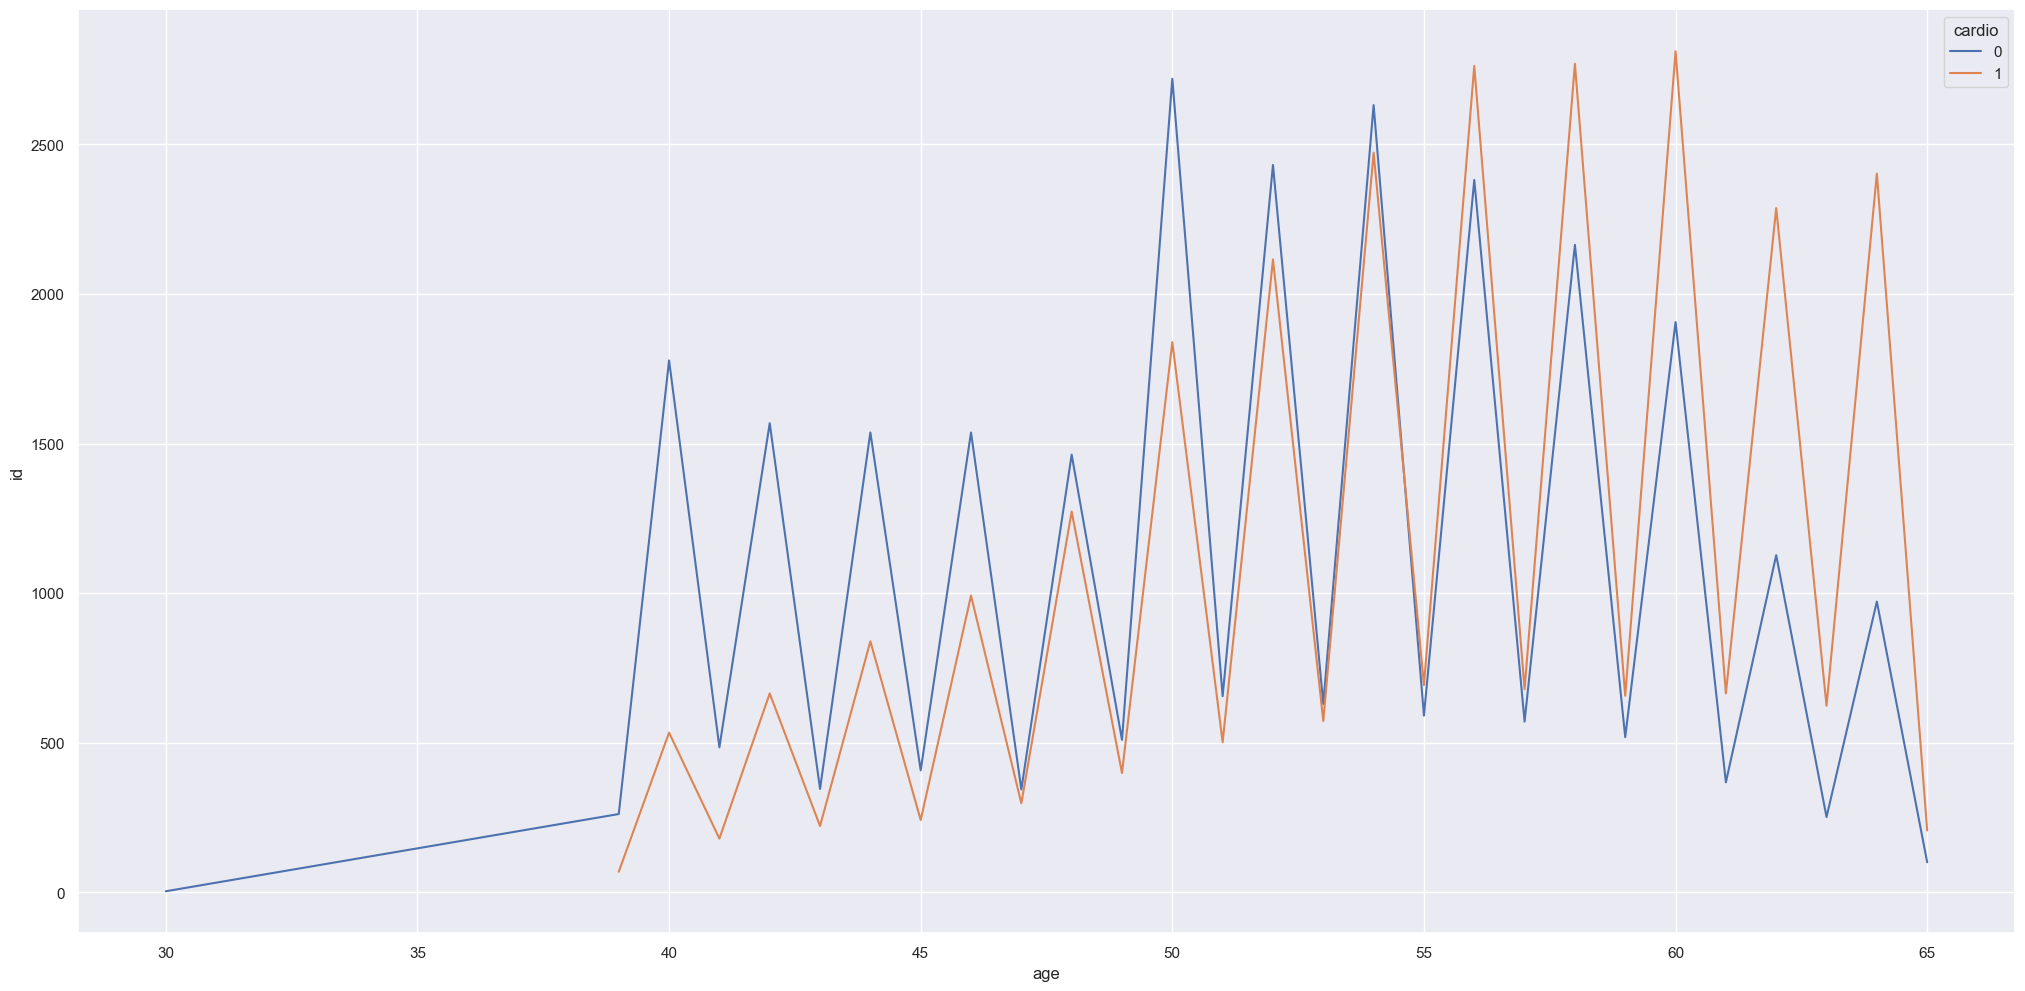

In [160]:
aux = df4[['age', 'cardio', 'id']].groupby( ['age', 'cardio'] ).count().reset_index()

sns.lineplot( data=aux, x='age', y='id', hue='cardio' )

### 5. Pessoas com indice de colesterol mais altos tendem a ter problemas cardiacos.
**Verdadeiro**: A porcentagem de pessoas com problemas cardiacos quando o nivel de colesterol é alto é maior

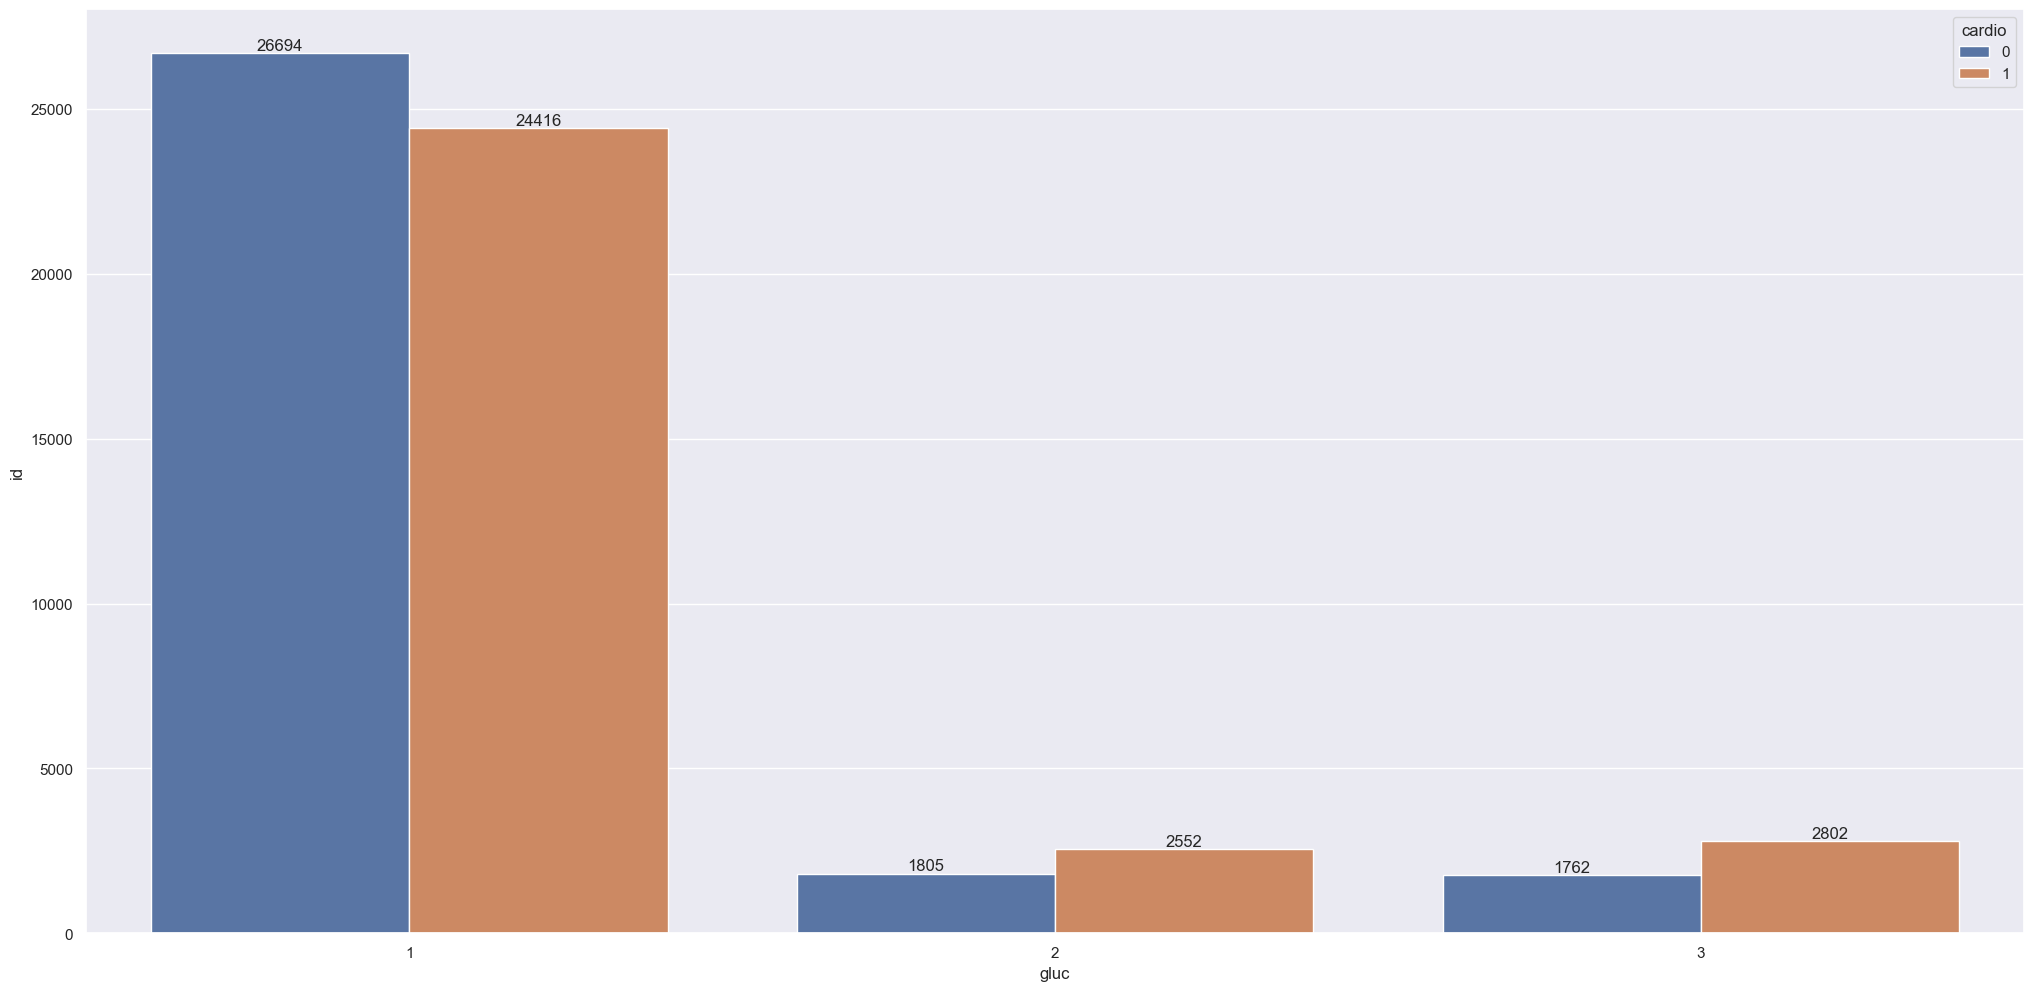

In [161]:
aux = df4[['gluc', 'cardio', 'id' ]].groupby( ['gluc', 'cardio'] ).count().reset_index()

ax = sns.barplot( data=aux, x='gluc', y='id', hue='cardio' )
for i in ax.containers:
    ax.bar_label(i,)

## 4.3. Multivariated Analysis

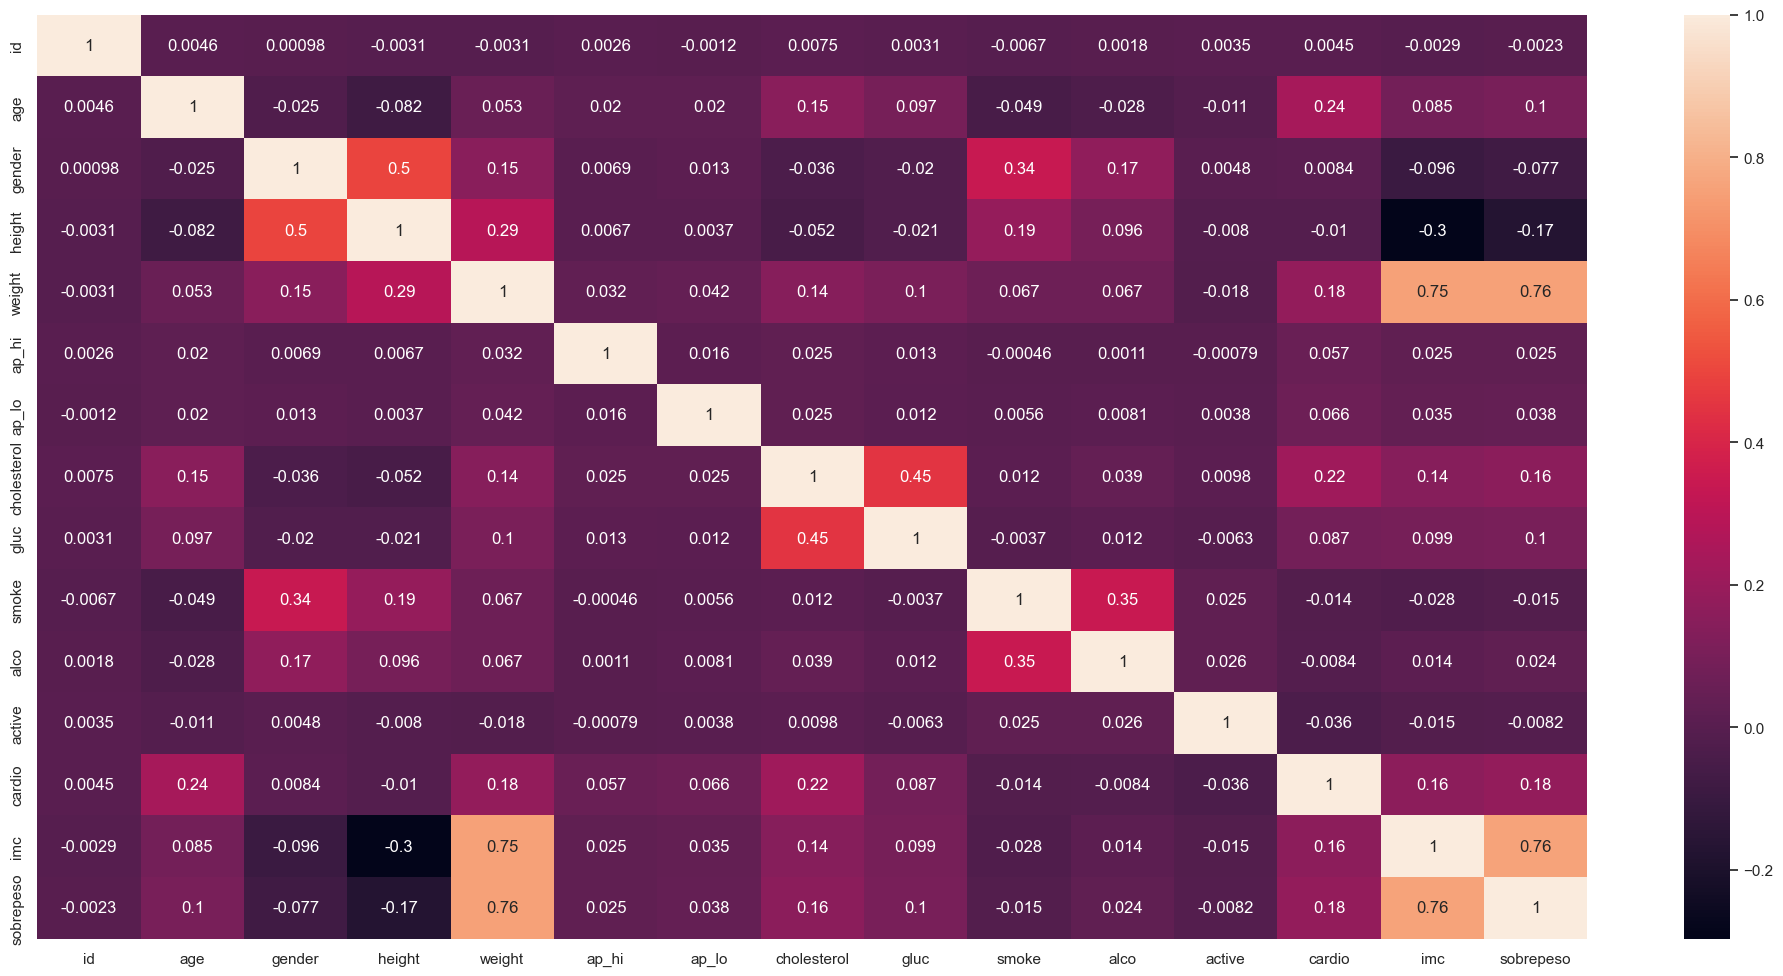

In [162]:
correlation = df2.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

# 5.0. Data Preparation

**Distribuição normal e não possui outliers -> Standard Scaler**

**Distribuição normal e possui outliers -> Robust Scaler**

**Não distribuição normal -> Min Max Scaler**

**Testes:**

**QQ Plot** -> Quantile Quantile Plot (Quantile teorica x Quantile Real)

**KS Teste** -> Kolgomorv Smirnoff (Teste de Hipoteses) Se p-value > 0.5 -> Distribuição Normal, p-value < 0.5 -> Não distribuição normal

**Detecção de outiliers:**

**Box Plot:**

IRQ * 2.5 -> Acima desse valor é Outlier

Z-Score > 3 -> Outlier

Z-Score < -3 -> Outlier

In [75]:
df5 = df4.copy()
df5_aux = df4.copy()

In [76]:
# Standand Scaler
mm = pp.MinMaxScaler() 
ss = pp.StandardScaler()
rs = pp.RobustScaler()

In [77]:
df5['age'] = ss.fit_transform( df5[['age']] )
df5['height'] = ss.fit_transform( df5[['height']] )
df5['weight'] = ss.fit_transform( df5[['weight']] )
df5['ap_hi'] = ss.fit_transform( df5[['ap_hi']] )
df5['ap_lo'] = ss.fit_transform( df5[['ap_lo']] )
df5['imc'] = ss.fit_transform( df5[['imc']] )

## Teste de Reescala

In [178]:
df5.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio', 'imc',
       'sobrepeso'],
      dtype='object')

In [170]:
variable = 'imc'

Min:13.76 - Max: 108.17


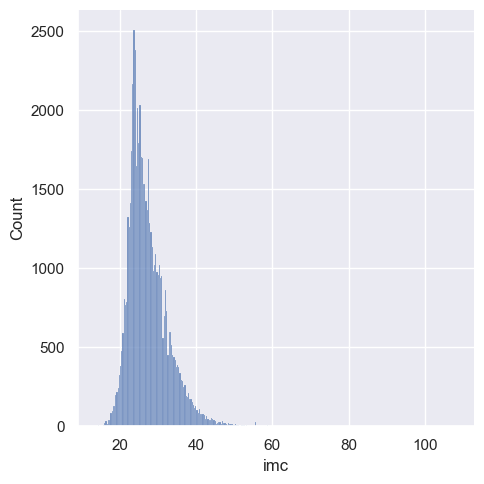

In [171]:
# Dados as IS
print( 'Min:{} - Max: {}'.format( df5_aux[variable].min(), df5_aux[variable].max() ) )
sns.displot(df5_aux[variable]);

Min:-2.017628205128205 - Max: 13.112179487179482


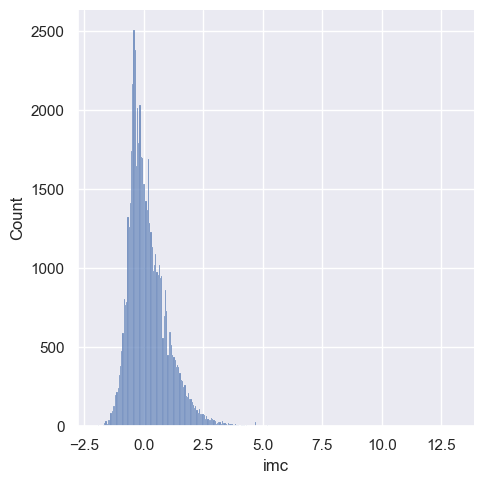

In [175]:
# Dados Normalizados ou Reescalados
print( 'Min:{} - Max: {}'.format( df5[variable].min(), df5[variable].max() ) )
sns.displot(df5[variable]);

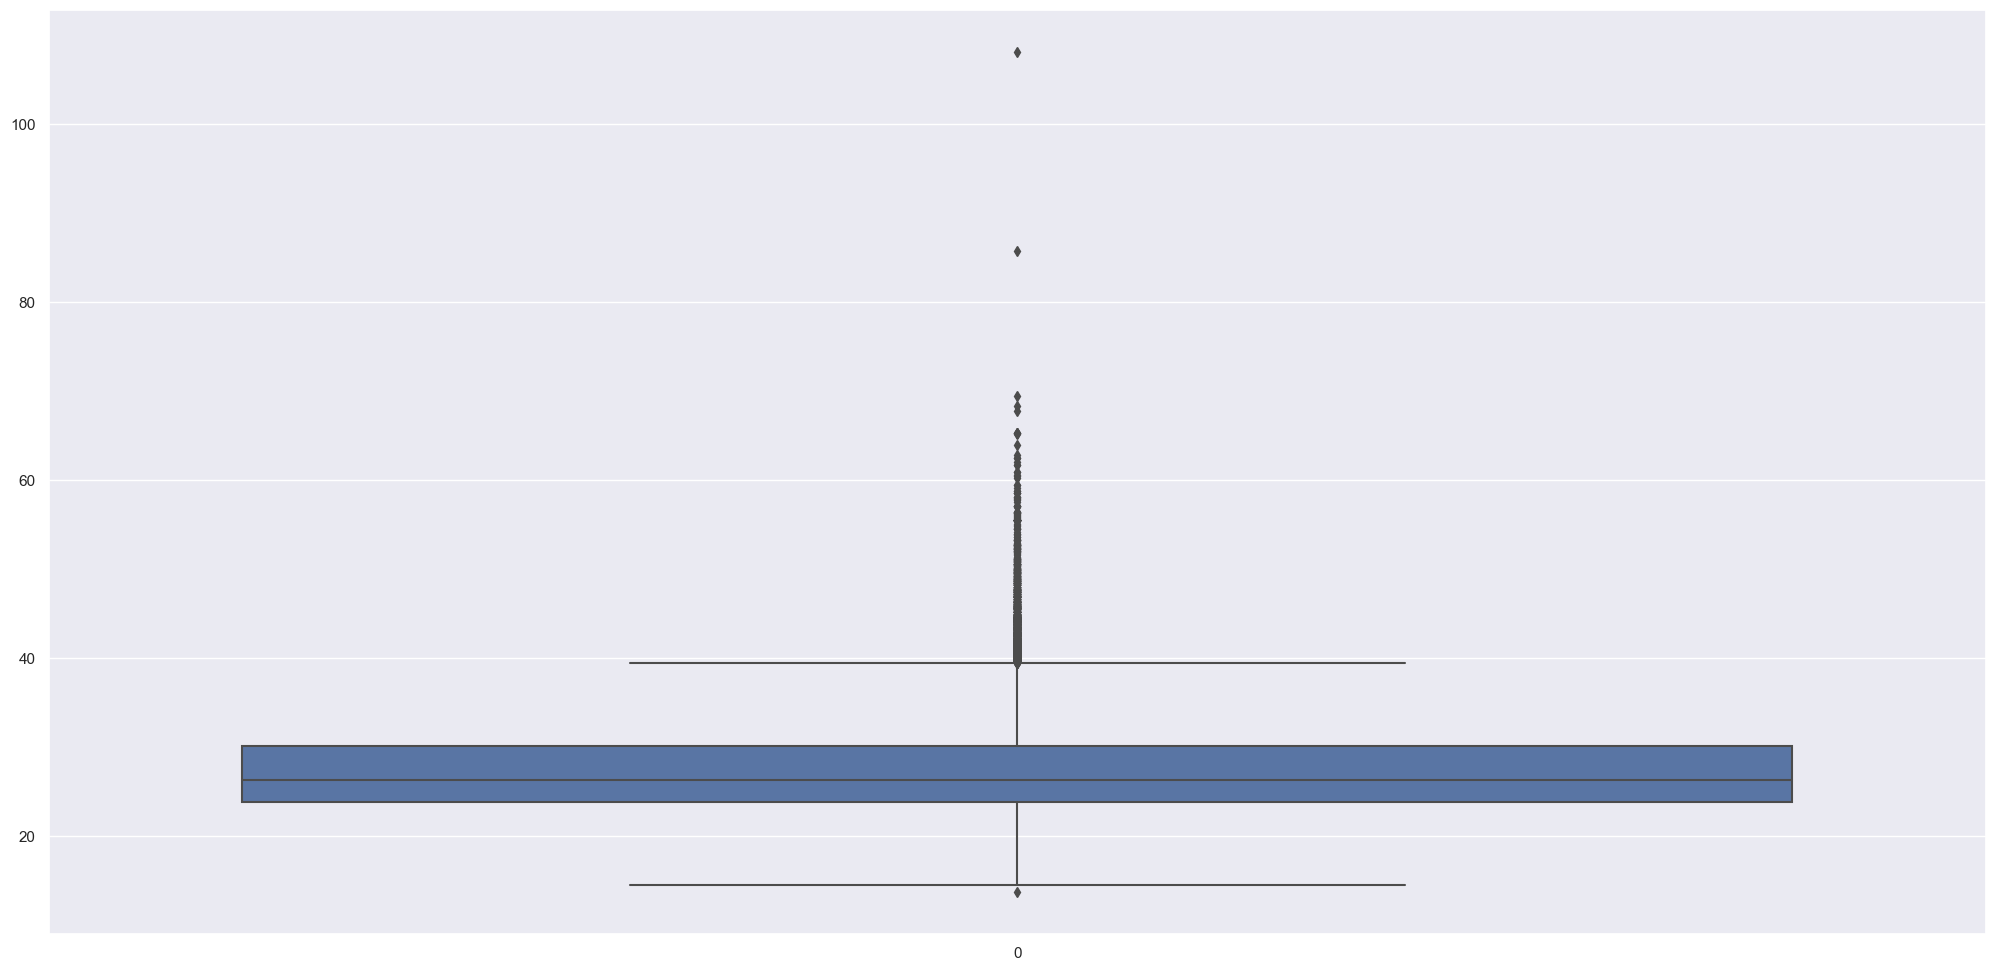

In [173]:
sns.boxplot( df5_aux[variable] );

# 6.0. Feature Selection

In [78]:
df6 = df5.copy()

In [79]:
X = df6.drop(['cardio', 'id'], axis=1)
y = df6['cardio'].copy()

x_train, x_validation, y_train, y_validation = train_test_split( X, y, test_size=0.20, random_state=28 )

In [80]:
# Model Definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=28, n_jobs=-1 )

# Data Preparation
x_train_n = x_train.copy()
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=28)

In [39]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print Feature Ranking
print('Feature Importance:')
df = pd.DataFrame()
for i, j in zip( x_train_n, importances ):
    aux = pd.DataFrame( {'feature':i, 'importance':j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print(df.sort_values('importance', ascending=False))

Feature Importance:
       feature  importance
0        ap_hi    0.170809
0          age    0.160979
0          imc    0.160456
0       weight    0.141774
0       height    0.141379
0        ap_lo    0.096551
0  cholesterol    0.044227
0    sobrepeso    0.023600
0         gluc    0.018280
0       gender    0.015296
0       active    0.010911
0        smoke    0.008531
0         alco    0.007209


In [81]:
cols_selected = ['ap_hi', 'age', 'imc', 'weight', 'height', 'ap_lo', 'cholesterol']

In [82]:
x_train = x_train[ cols_selected ]
x_val = x_validation [ cols_selected ]
y_val = y_validation.copy()

# 7.0. Model Selection

In [83]:
df7 = df6.copy()

## 7.1. KNN Model

In [84]:
# Model Definition
knn_model = nh.KNeighborsClassifier( n_neighbors=8 )

# Model Training
knn_model.fit( x_train, y_train )

# Model Prediction
yhat_knn = knn_model.predict( x_val )

# Metrics
knn_f1score = f1_score(y_val, yhat_knn)
knn_accuracy = accuracy_score( y_val, yhat_knn)
knn_recall = recall_score( y_val, yhat_knn, average='binary'  )

print('F1 Score: {}'.format(knn_f1score) )
print('Accuracy Score: {}'.format( knn_accuracy ) )
print('Recall Score: {} '.format( knn_recall ) )

F1 Score: 0.6742908599729852
Accuracy Score: 0.6987590572166237
Recall Score: 0.6190476190476191 


### KNN Cross Validation

In [46]:
knn_cv = cross_validation( ' KNN CV', knn_model, X, y )

## 7.2. Logistic Regression

In [85]:
# Model Definition
lr_model = lm.LogisticRegression( random_state=28 )

# Model Training
lr_model.fit( x_train, y_train )

# Model Prediction
yhat_lr = lr_model.predict( x_val )

lr_f1score = f1_score(y_val, yhat_lr)
lr_accuracy = accuracy_score( y_val, yhat_lr)
lr_recall = recall_score( y_val, yhat_lr, average='binary'  )


print('F1 Score: {}'.format( lr_f1score) )
print('Accuracy Score: {}'.format( lr_accuracy ) )
print('Recall Score: {}'.format( lr_recall ) )

F1 Score: 0.6995038979447201
Accuracy Score: 0.7174981260931124
Recall Score: 0.6527777777777778


### LR Cross Validation

In [48]:
lr_cv = cross_validation( 'Logistic Regression CV', lr_model, X, y )

C:\Users\Pedro\repos\cardio_diseases\cardio_env\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Pedro\repos\cardio_diseases\cardio_env\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

## 7.3. Extra Trees

In [86]:
# Model Definition
et_model = en.ExtraTreesClassifier( n_estimators=1000, n_jobs=-1, random_state=42 )

# Model Training
et_model.fit( x_train, y_train )

# Model Prediction 
yhat_et = et_model.predict( x_val )

et_f1score = f1_score(y_val, yhat_et)
et_accuracy = accuracy_score( y_val, yhat_et)
et_recall = recall_score( y_validation, yhat_et, average='binary'  )


print('F1 Score: {}'.format( et_f1score) )
print('Accuracy Score: {}'.format( et_accuracy ) )
print('Recall Score: {}'.format( et_recall ) )

F1 Score: 0.6789300480972069
Accuracy Score: 0.6831015241109353
Recall Score: 0.6651785714285714


### Extra Tress Cross Validation

In [51]:
et_cv = cross_validation( 'Extra Trees CV', et_model, X, y )

## 7.4. Random Forest

In [87]:
# model definition
rf_model = en.RandomForestClassifier( n_estimators=1000, n_jobs=-1, random_state=42 ) 

# model training
rf_model.fit( x_train, y_train )

# model prediction
yhat_rf = rf_model.predict( x_val )

rf_f1score = f1_score(y_validation, yhat_rf)
rf_accuracy = accuracy_score( y_val, yhat_rf)
rf_recall = recall_score( y_val, yhat_rf, average='binary' ) 

print ('F1 Score: {}'.format( rf_f1score ) )
print('Accuracy Score: {}'.format( rf_accuracy ) )
print('Recall Score: {}'.format( rf_recall ) )

F1 Score: 0.6885880077369438
Accuracy Score: 0.6915965686682768
Recall Score: 0.6769179894179894


### Random Forest Cross Validation

In [53]:
rf_cv = cross_validation( 'Random Forest CV', rf_model, X, y )

## 7.5. Light Gradient Boosting Machine

In [88]:
lgbm_model = LGBMClassifier()

lgbm_model.fit(x_train, y_train)

yhat_lgbm = lgbm_model.predict( x_val )


lgbm_f1score = f1_score(y_val, yhat_lgbm)
lgbm_accuracy = accuracy_score( y_val, yhat_lgbm)
lgbm_recall = recall_score( y_val, yhat_lgbm, average='binary' ) 

print('F1 Score: {}'.format( lgbm_f1score ) )
print('Accuracy Score: {}'.format( lgbm_accuracy ) )
print('Recall Score: {}'.format( lgbm_recall ) )

F1 Score: 0.7103472343395567
Accuracy Score: 0.7234946281335888
Recall Score: 0.6731150793650794


### LGBM Cross Validation

In [55]:
lgbm_cv = cross_validation( 'LGBM CV', lgbm_model, X, y )

## Results

In [89]:
results = {'Metric':['F1 Score', 'Accuracy Score', 'Recall Score'], 'KNN': [knn_f1score, knn_accuracy, knn_recall], 
           'Logistic Regression': [lr_f1score, lr_accuracy, lr_recall], 'Extra Trees': [et_f1score, et_accuracy, et_recall], 
           'Random Forest': [rf_f1score, rf_accuracy, rf_recall], 'LGBM': [lgbm_f1score, lgbm_accuracy, lgbm_recall]}
df_results = pd.DataFrame( data=results).T

In [90]:
df_results.columns = df_results.iloc[0]
df_results =df_results[1:]
df_results

Metric,F1 Score,Accuracy Score,Recall Score
KNN,0.674291,0.698759,0.619048
Logistic Regression,0.699504,0.717498,0.652778
Extra Trees,0.67893,0.683102,0.665179
Random Forest,0.688588,0.691597,0.676918
LGBM,0.710347,0.723495,0.673115


## Cross Validation Results

In [62]:
results_cv = pd.concat( [knn_cv, lr_cv, et_cv, rf_cv, lgbm_cv] )
results_cv

,Accuracy Score,F1 Score,Recall Score
KNN CV,0.7 +/- 0.004,0.673 +/- 0.004,0.624 +/- 0.004
Logistic Regression CV,0.724 +/- 0.003,0.704 +/- 0.003,0.663 +/- 0.005
Extra Trees CV,0.694 +/- 0.003,0.69 +/- 0.003,0.685 +/- 0.004
Random Forest CV,0.705 +/- 0.004,0.7 +/- 0.004,0.693 +/- 0.006
LGBM CV,0.731 +/- 0.004,0.716 +/- 0.004,0.685 +/- 0.004


# 8.0. Hyper-parameter Fine Tuning

# 9.0. Testing Model

# 10.0. Business Performance